<a href="https://colab.research.google.com/github/rsethi21/foldingML/blob/main/GO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0069573

# Fit Data

In [1]:
data = {
  "1": {
    "450": 1.0,

    "1950": 0.2,

    "2110": 0.8,
  },
  "2": {
    "450": 1.0,

    "1950": 0.6,

    "2110": 1.4,

  },
  "7": {
    "450": 1.0,

    "1950": 0.7,

    "2110": 1.1,
  }
}

# Imports

In [2]:
!pip install geneticalgorithm2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 5.6 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy import misc
import pandas
from geneticalgorithm2 import geneticalgorithm2 as ga
import json
import argparse
import warnings

# Genetic algorithm fitting

## Function with Goodwin Oscillator

In [4]:
def simulation_fn(y,t,K,lps=None,hdaci=None):
  Akt, pAkt, pPTEN, PTEN, PIP2, PIP3, PI3K, GSK3B, pGSK3B, LPS, HDACi = y
## rate constants:

  k1 = K[0]
  k2 = K[1]
  k5 = K[2]
  k6 = K[3]
  k7 = K[4]
  k8 = K[5]
  k9 = K[6]
  k10 = K[7]
  i1 = K[8]
  i2 = K[15]
  Km1 = K[9]
  n1 = K[12]
  Km2 = K[10]
  n2 = K[13]
  Km3 = K[11]
  n3 = K[14]
  k3 = 1
  k4 = 1

## Differential Equations: ask which one is more accurate

  dPI3Kdt = k3-k4*PI3K

  dPIP2dt = k6*PIP3 - k5*PIP2*PI3K*((Km1**n1)/(Km1**n1 + PTEN**n1))
  dPIP3dt = -k6*PIP3 + k5*PIP2*PI3K*((Km1**n1)/(Km1**n1 + PTEN**n1))

  dAktdt = k2*pAkt - k1*((PIP3**2)/(1 + PIP3**2))*Akt
  dpAktdt = -k2*pAkt + k1*((PIP3**2)/(1 + PIP3**2))*Akt

  dPTENdt = k7*pPTEN*((Km2**n2)/(Km2**n2+ GSK3B**n2)) - k8*PTEN + i1*LPS
  dpPTENdt = -k7*pPTEN*((Km2**n2)/(Km2**n2+ GSK3B**n2)) + k8*PTEN - i1*LPS

  dGSK3Bdt = k9*pGSK3B*((Km3**n3)/(Km3**n3+ pAkt**n3)) - k10*GSK3B + i2*HDACi
  dpGSK3Bdt = -k9*pGSK3B*((Km3**n3)/(Km3**n3+ pAkt**n3)) + k10*GSK3B - i2*HDACi

  dLPSdt = 0
  dHDACidt = 0

  if lps != None:

    if lps[2] <= t < lps[3]:
      dLPSdt = lps[1] - LPS
    elif t < lps[2]:
      dLPSdt = 0
    else:
      dLPSdt = -LPS

  if hdaci != None:
    if hdaci[2] <= t < hdaci[3]:
      dHDACidt = hdaci[1] - HDACi
    elif t < hdaci[2]:
      dHDACidt = 0
    else:
      dHDACidt = -HDACi

  dydt = [dAktdt, dpAktdt, dpPTENdt, dPTENdt, dPIP2dt, dPIP3dt, dPI3Kdt, dGSK3Bdt, dpGSK3Bdt, dLPSdt, dHDACidt]
  return dydt

In [5]:
def findSteadyState(arr, times):

  def f(t):
    return arr[t, :]

  steadyTime = times[-1]

  for time in times:
    deriv = misc.derivative(f, time, dx = 1)
    for d in deriv:
      if d < 10**-4:
        steadyTime = time
      else:
        steadyTime = times[-1]
        break

    if steadyTime != times[-1]:
      return steadyTime
    else:
      continue

    return steadyTime

## Apply

In [21]:


time = np.linspace(0, 4000, 4000)
yi = np.array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0], dtype="float")
y = odeint(simulation_fn, yi, time, args=(best_params, None, None))
steady = list(y[findSteadyState(y, [i for i in range(0, 3999)]), :])
y2 = odeint(simulation_fn, steady, time, args=(best_params, (True, 1.0, 500, 1940), (True, 1.0, 2000, 2120)))

print(findSteadyState(y, [i for i in range(0, 3999)]))

y2[:, 0:9] = y2[:, 0:9]/steady[0:9]

76


<ipython-input-5-f740f207bd81>:9: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  deriv = misc.derivative(f, time, dx = 1)


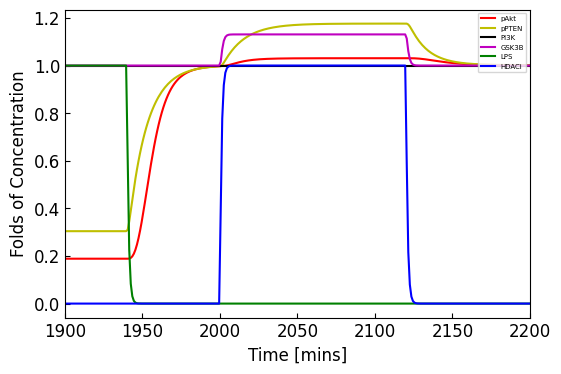

In [23]:
plt.figure(figsize=(6,4),dpi=100)
plt.xlim(1900, 2200)
plt.plot(time,y2[:,1],'r-',label='pAkt')
plt.plot(time,y2[:,2],'y-',label='pPTEN')
plt.plot(time,y2[:,6],'k-',label='PI3K')
plt.plot(time,y2[:,7],'m-',label='GSK3B')
plt.plot(time,y2[:,9],'g-',label='LPS')
plt.plot(time,y2[:,10],'b-',label='HDACi')

plt.tick_params(direction='in',labelsize=12)
plt.xlabel('Time [mins]',fontsize=12)
plt.ylabel('Folds of Concentration',fontsize=12)
plt.legend(loc='upper right',fontsize=5)

## Fitting

In [11]:
def predictions(simulation_fn, K):
  time = np.linspace(0, 4000, 4000)

  yi = np.array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0], dtype="float")
  y = odeint(simulation_fn, yi, time, args=(K, None, None))
  steady = list(y[findSteadyState(y, [i for i in range(0, 3999)]), :])
  newy = odeint(simulation_fn, steady, time, args=(K, (True, 1.0, 500, 1940), (True, 1.0, 2000, 2120)))

  newy[:, 0:9] = newy[:, 0:9]/steady[0:9]

  return newy

In [12]:
def obj_fn(X):

  expl_data = data
  cost = 0
  count = 0
  pred = predictions(simulation_fn, X)
  for proteinID, information in expl_data.items():
    for time, value in information.items():
      cost += (pred[int(time), int(proteinID)] - float(value))**2
      count += 1

  return float(cost)/count

In [13]:
varbound = np.array([[0.01,1]]*8 + [[0.001, 0.1]] + [[0.01, 1]]*3+ [[1, 8]]*3 + [[0.001, 0.1]])

algorithm_param = {'max_num_iteration': 30,\
                   'population_size':50,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv': 25}

In [14]:
model=ga(function=obj_fn,\
            dimension=16,\
            variable_type_mixed=('real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'int', 'int', 'int', 'real'),\
            variable_boundaries=varbound,\
            algorithm_parameters=algorithm_param)


Set: Average time of function evaluating (secs): 0.14943353652954103 (total = 7.471676826477051)

Best score before optimization: 0.047292925618510874
                                                                                                                                                                                                        
 The best found solution:
 [0.16667895 0.67607308 0.07405058 0.11688849 0.11757552 0.06348209
 0.58542863 0.82115276 0.0442021  0.61777582 0.34654988 0.87547098
 4.         8.         8.         0.07657945]

 Objective function:
 0.02610446968578294

 Used generations: 30
 Used time: 79.1 seconds


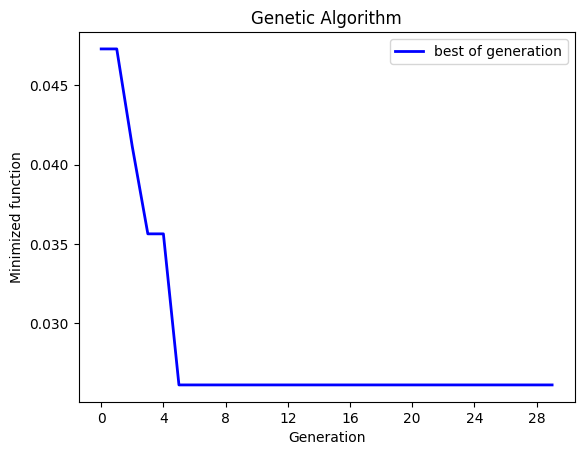

GAResult(last_generation=Generation(variables=array([[0.16667895, 0.67607308, 0.07405058, 0.11688849, 0.11757552,
        0.06348209, 0.58542863, 0.82115276, 0.0442021 , 0.61777582,
        0.34654988, 0.87547098, 4.        , 8.        , 8.        ,
        0.07657945],
       [0.12854526, 0.67607308, 0.77198307, 0.72752462, 0.61607311,
        0.06348209, 0.58542863, 0.82115276, 0.09182975, 0.61777582,
        0.30427009, 0.87547098, 4.        , 8.        , 4.        ,
        0.09813379],
       [0.16667895, 0.67607308, 0.07405058, 0.11688849, 0.11757552,
        0.06348209, 0.58542863, 0.82115276, 0.0442021 , 0.61777582,
        0.34654988, 0.87547098, 7.        , 1.        , 8.        ,
        0.07657945],
       [0.16667895, 0.67607308, 0.07405058, 0.11688849, 0.11757552,
        0.06348209, 0.58542863, 0.82115276, 0.07571102, 0.44938049,
        0.34654988, 0.82928249, 3.        , 1.        , 4.        ,
        0.07724197],
       [0.5637657 , 0.54090038, 0.09933939, 0.73864132

In [15]:
model.run(set_function=ga.set_function_multiprocess(obj_fn, n_jobs=-1))

In [19]:
best_params = model.result.variable

In [20]:
best_params

array([0.16667895, 0.67607308, 0.07405058, 0.11688849, 0.11757552,
       0.06348209, 0.58542863, 0.82115276, 0.0442021 , 0.61777582,
       0.34654988, 0.87547098, 4.        , 8.        , 8.        ,
       0.07657945])